# Treatment for Malocclusion

## Assignment

In this assignment we are going to analyse scull measurement data of patients with malocclusion. Patients affected by Class III malocclusion (characterised by the protrusion of lower dental arch) suffer from a skeletal imbalance that is established early in life, and that becomes more pronounced during puberty and until skeletal maturation is complete. Predicting treatment success or failure early in a single Class III patient makes it easier to correct it, but it is difficult to do just from a small number of morphometric determinants is problematic. The reason for that is that Class III malocclusion is rarely a consequence of an abnormality in a single craniofacial component, so individual clinical and radiological measurements are likely to be less indicative than the interplay between the measurements themselves.

The data set we will use contains 143 patients with two sets of measurements at ages T1 and T2 (measured in years) for the following variables:

* Treatment: untreated (0) or treated (1).
* Growth: a binary variable with values Good or Bad, determined on the basis of CoGn-CoA.
* ANB: angle between Down's points A and B (degrees).
* IMPA: incisor-mandibular plane angle (degrees).
* PPPM: palatal plane - mandibular plane angle (degrees).
* CoA: total maxillary length from condilion to Down's point A (mm).
* GoPg: length of mandibular body from gonion to pogonion (mm).
* CoGo: length of mandibular ramus from condilion to pogonion (mm).

All the measurements are taken from x-ray scans using a set of reference points established using a map like the following:

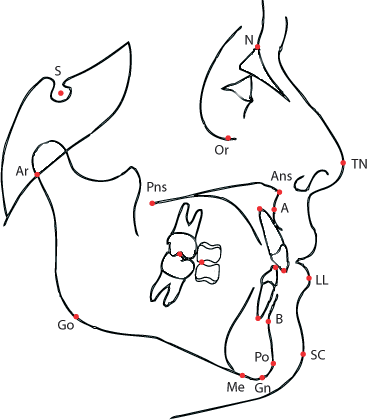

For simplicity, we transform the dataset by taking differences between time points T2 and T1, so all features now represent changes in measurements.
We would like to estimate the effect of the treatment on Growth and dANB by taking into account causal relationships between variables. Our knowledge of those causal relationships is represented on the following DAG:

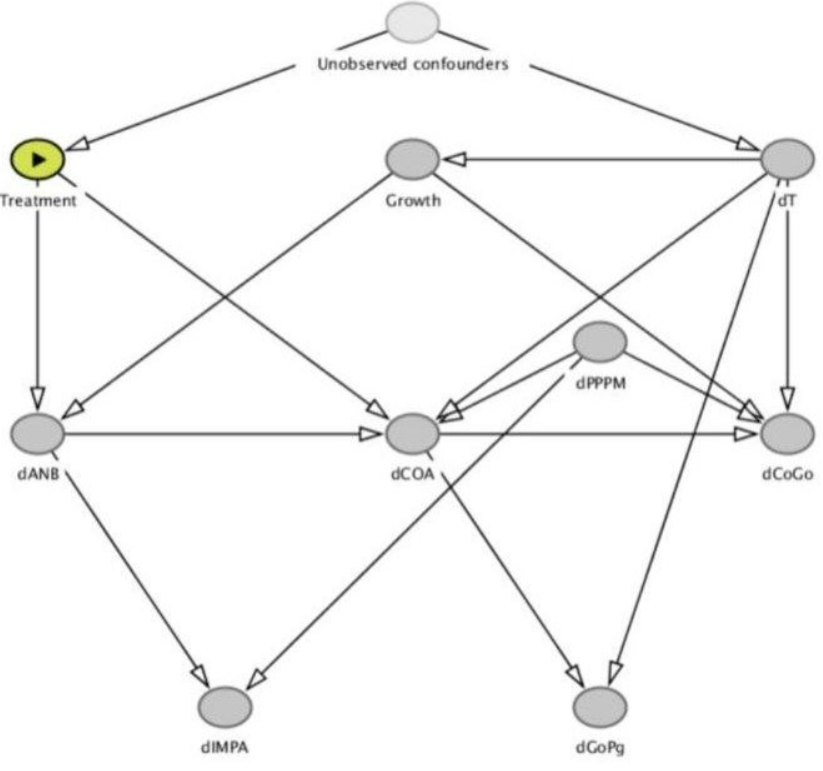

Treatment assignment, Growth and number of years between two measurements are likely to be affected by some unobserved confounders, as the graph shows.

Given the graph, select the variables to condition on, apply suitable adjustment method, and calculate your estimates of causal effects: Treatment on Growth, Treatment on dANB, both ATE and ATET.


The dataset is taken from Scutari, M., Auconi, P., Caldarelli, G., Franchi, L. (2017) Bayesian Networks Analysis of Malocclusion Data. Scientific Reports , 7, 15236.

Your analysis should contain:

* Selection of covariates to adjust for (informed by the graph)
* Application of the most suitable adjustment method
* Estimates of the ATE and ATET

The maximal grade for the assignment is 25 points , where for each of two estimated causal effects you could get:

* a maximum of 6.5 points for correct and optimal selection of the adjustment set,
* a maximum of 3 points for correct estimation of the ATE,
* a maximum of 3 points for correct estimation of the ATET.

## Analysis

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from causalinference import CausalModel

In [2]:
df = pd.read_csv('malocclusion.csv')
df.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0


## 1. Causal Effect of Treatment on Growth

### Selection of covariates to adjust for

There is no directed path from `Treatment` to `Growth`.
Also, there is no intermediate variable (mediator) that acts as a direct link between `Treatment` and `Growth`.

While `Growth` is influenced by several other variables (e.g., `dANB`, `dPPPM`), these variables themselves do not have direct paths from `Treatment`.

Given the current structure of the DAG, there is no direct or indirect causal link established between `Treatment` and `Growth`. Causal inference typically relies on the presence of causal paths, and in this case, such paths do not exist in the represented structure.

As a result no covariates selected to adjust for.

### Application of the most suitable adjustment method

Having no causal link from `Treatment` to `Growth` and no covariates selected, no adjustment method was applied.

### Estimates of the ATE and ATET

Naive estimator of ATE:

In [3]:
print(f'ATE: {df.Growth[df.Treatment == 1].mean() - df.Growth[df.Treatment == 0].mean()}')

ATE: 0.1471861471861472


However, the estimate above have no statistical significance for the following reasons:

Causal inference relies on the existence of causal paths connecting the treatment and outcome variables. In the absence of a direct causal link and no identified mediators, there is no clear basis for estimating a causal effect.

ATE represents the average effect of a treatment on an outcome, assuming a causal mechanism exists. Without a direct causal path or intermediary variables to convey the effect of the treatment on growth, the ATE lacks a meaningful interpretation.

Even though we can calculate the ATE mathematically, the result is statistically limited and is unlikely to have practical or substantive significance because it doesn't reflect an actually exising causal relationship.

Moreover, attempting to estimate an ATE without a direct causal link can introduce bias and confounding. In the absence of a valid causal relationship, other unaccounted-for factors or unobserved confounders can give misleading results.

## 2. Causal Effect of Treatment on dANB

### Selection of covariates to adjust for

Nodes `Treatment` and `dANB` are d-connected through 2 paths:
* a direct link from `Treatment` to `dANB` for which we need to estimate the causal effect;
* another path `Treatment` <- `Unobserved confounders` -> `dT` -> `Growth` -> `dANB`.

All other paths between the two variables of interest make them d-separated and we shall not adjust for colliders in order not to introduce additional bias.

The simplest way would be to adjust on the parent of `Treatment` but it is cannot be measured. Basing on Ignorability assumption, after conditioning on observed covariates we consider any unmeasured covariates irrelevant. This enables us to ingnore the `Unobserved confounders` and leaves us with only two covariates we can condition on, i.e. `dT` and `Growth`. As a matter of fact, we have three valid adjustment sets: {`Growth`}, {`dT`} and {`Growth`, `dT`} which make `Treatment` and `dANB` d-connected conditioned on adjustment set. 

These adjustment sets contain no descendants of any node on a directed path from `Treatment` to `dANB` ans block all non-directed paths from from `Treatment` to `dANB`.

In order to decide which adjustment set is more appropriate let us adjust on all three of them and compare the resuls.

In [4]:
sets = {
    'set_1': 'Treatment + Growth',
    'set_2': 'Treatment + dT',
    'set_3': 'Treatment + Growth + dT'
}

for set_name, set_formula in sets.items():
    print(f'\nSet: {set_formula}\n')
    results = smf.ols('dANB ~ ' + set_formula, data=df).fit()
    sets[set_name] = [results.tvalues, results.pvalues]
    print(results.summary())


Set: Treatment + Growth

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     48.04
Date:                Sun, 22 Oct 2023   Prob (F-statistic):           1.31e-16
Time:                        23:41:51   Log-Likelihood:                -251.17
No. Observations:                 143   AIC:                             508.3
Df Residuals:                     140   BIC:                             517.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5600     

In [5]:
t_values = [set_results[0] for set_results in sets.values()]
p_values = [set_results[1] for set_results in sets.values()]

selection = ['Growth', 'dT']
display('t-values:', pd.concat(t_values, axis=1).T[selection])     
display('p-values:', pd.concat(p_values, axis=1).T[selection])

't-values:'

,Growth,dT
0,4.812106,NaN
1,NaN,-1.409047
2,4.624577,-0.758385


'p-values:'

,Growth,dT
0,0.000004,NaN
1,NaN,0.161039
2,0.000008,0.449505


> The t-statistic measures the significance of the coefficient estimate. A high absolute t-statistic (with a low p-value) suggests that the variable is a significant predictor of the dependent variable.<br>
> P>|t|: The p-value associated with the t-statistic, indicating the significance of the variable.

It can be seen that in this case variable `dT` shows much lower significance with regard to the target variable prediction, as it has negative t-statistic and large p-values. For this reason we may consider omitting covariate `dT` and adjusting for `Growth` only.

### Application of the most suitable adjustment method, ATE/ATET calculation

Naive estimator:

In [6]:
print(f'ATE: {df.dANB[df.Treatment == 1].mean() - df.dANB[df.Treatment == 0].mean()}')

ATE: 2.0287878787878784


#### Regression

In [7]:
model = smf.ols('dANB ~ Treatment + Growth', data=df)
results_ols_ate = model.fit()
print(results_ols_ate.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     48.04
Date:                Sun, 22 Oct 2023   Prob (F-statistic):           1.31e-16
Time:                        23:41:51   Log-Likelihood:                -251.17
No. Observations:                 143   AIC:                             508.3
Df Residuals:                     140   BIC:                             517.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5600      0.181     -8.609      0.0

In [8]:
df_treated = df[df.Treatment == 1]
model = smf.ols('dANB ~ Treatment + Growth', data=df_treated)
results_ols_atet = model.fit()
print(results_ols_atet.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.17
Date:                Sun, 22 Oct 2023   Prob (F-statistic):            0.00139
Time:                        23:41:51   Log-Likelihood:                -114.55
No. Observations:                  66   AIC:                             233.1
Df Residuals:                      64   BIC:                             237.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1544      0.120      1.292      0.2

In [9]:
print(f'ATE  = {results_ols_ate.params["Treatment"]}')
print(f'ATET = {results_ols_atet.params["Treatment"]}')

ATE  = 1.8559944422389845
ATET = 0.15441176470588217


However, we are dealing wit a random representative sample from the population.

Sample average treatment effect (SATE) is an estimator for population ATE. 

Because treatment assignment is random the difference between two sample averages in the treatment group and the control group (average SATE) is an unbiased estimate of SATE. <br>
Because the sample is representative average SATE is an estimator of population ATE.<br>
Also because the treatment assignment is random ATET is equal to ATE.

In this connection we do not need to pass to our models filtered dataset `df[df.Treatment == 1]` and shoul consider ATE only.

#### Propensity weights

In [10]:
covariates = 'Growth'

propensity_formula = 'Treatment ~ ' + covariates
model_propensity = smf.logit(formula=propensity_formula, data=df)
results_propensity = model_propensity.fit()

propensity_scores = results_propensity.predict()

df['pscore'] = propensity_scores

Optimization terminated successfully.
         Current function value: 0.679004
         Iterations 4


#### Matching with Machalanobis distance

In [18]:
causal = CausalModel(
    Y=df['dANB'].values,
    D=df['Treatment'].values,
    X=df['Growth'].values
)

In [19]:
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761      0.000      1.390      2.330
           ATT      1.852      0.240      7.723      0.000      1.382      2.322



#### Propensity score matching

In [21]:
causal = CausalModel(
    Y=df['dANB'].values,
    D=df['Treatment'].values,
    X=df['pscore'].values
)

In [22]:
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761      0.000      1.390      2.330
           ATT      1.852      0.240      7.723      0.000      1.382      2.322



### Back to regression

In [23]:
causal = CausalModel(
    Y=df['dANB'].values,
    D=df['Treatment'].values,
    X=df['Growth'].values
)

In [24]:
causal.est_via_ols(adj=1)
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.239      7.752      0.000      1.387      2.325



In [27]:
causal.est_via_ols(adj=2)
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.240      7.743      0.000      1.386      2.326
           ATC      1.860      0.245      7.580      0.000      1.379      2.341
           ATT      1.852      0.239      7.760      0.000      1.384      2.320



Parameters for est_via_ols() <br>
adj: int (0, 1, or 2) <br>
Indicates how covariate adjustments are to be performed. Set adj = 0 to not include any covariates. Set adj = 1 to include treatment indicator D and covariates X separately. Set adj = 2 to additionally include interaction terms between D and X. Defaults to 2.

Presence of ATT figure for adj = 2 and it equivalence to ATT for est_via_matching() implies that in this calculation interaction between `Treatment` ang `Growth` is included. This fact supports the remark made above that for the sample we should consider ATE only (SATE as a matter of fact) considering it equal to ATET.